In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

import monai
from monai.config import print_config

from monai.apps.deepedit.transforms import (
    AddGuidanceSignalDeepEditd,
    AddGuidanceFromPointsDeepEditd,
    ResizeGuidanceMultipleLabelDeepEditd,
)
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Resized,
    ScaleIntensityRanged,
    SqueezeDimd,
    ToNumpyd,
    ToTensord,
)
from monai.networks.nets import DynUNet

print_config()

c:\Users\gusdb\anaconda3\envs\TotalSegmentator\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.5.0
Numpy version: 2.2.6
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: c:\Users\<username>\anaconda3\envs\TotalSegmentator\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 10.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

F

In [2]:
def draw_points(guidance, slice_idx):
    if guidance is None:
        return
    for p in guidance:
        p1 = p[1]
        p2 = p[0]
        plt.plot(p1, p2, "r+", "MarkerSize", 30)


def show_image(image, label, guidance=None, slice_idx=None):
    plt.figure("check", (12, 12))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, "jet", interpolation="none", alpha=0.7)

    draw_points(guidance, slice_idx)
    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
        # draw_points(guidance, slice_idx)
    plt.show()


def print_data(data):
    for k in data:
        v = data[k]

        d = type(v)
        if type(v) in (int, float, bool, str, dict, tuple):
            d = v
        elif hasattr(v, "shape"):
            d = v.shape

        if k in ("image_meta_dict", "label_meta_dict"):
            for m in data[k]:
                print("{} Meta:: {} => {}".format(k, m, data[k][m]))
        else:
            print("Data key: {} = {}".format(k, d))

In [3]:
# labels
labels = {"spleen": 1, "background": 0}

spatial_size = [128, 128, 128]


model = DynUNet(
    spatial_dims=3,
    in_channels=len(labels) + 1,
    out_channels=len(labels),
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, [2, 2, 1]],
    upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
)

In [4]:
# Download data and model

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/_image.nii.gz"
dst = "_image.nii.gz"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/\
download/0.8.1/pretrained_deepedit_dynunet-final.pt"
dst = "pretrained_deepedit_dynunet-final.pt"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

pretrained_deepedit_dynunet-final.pt: 118MB [00:05, 21.2MB/s]                              

2025-08-13 20:23:40,071 - INFO - Downloaded: pretrained_deepedit_dynunet-final.pt
2025-08-13 20:23:40,071 - INFO - Expected md5 is None, skip md5 check for file pretrained_deepedit_dynunet-final.pt.


c:\Users\gusdb\anaconda3\envs\TotalSegmentator\lib\site-packages\monai\transforms\io\array.py:213: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


LoadImaged => image shape: torch.Size([392, 392, 210])


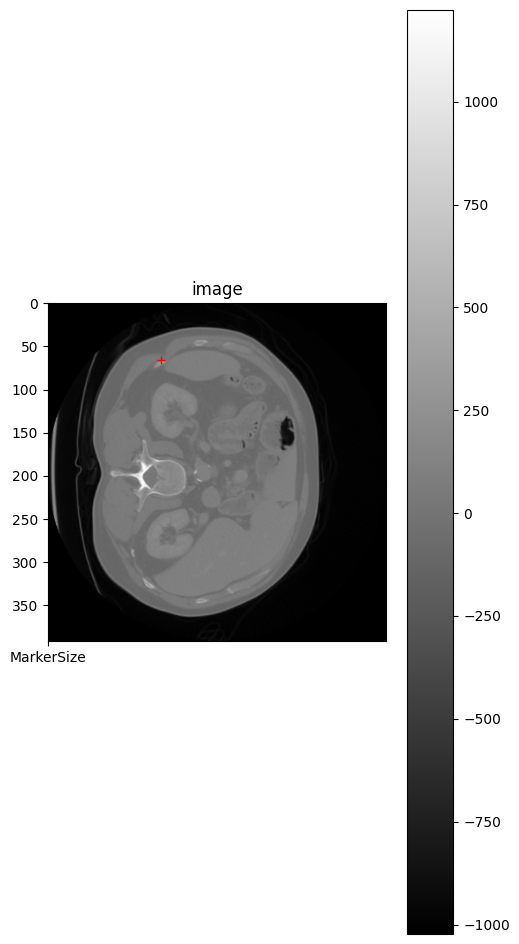

EnsureChannelFirstd => image shape: torch.Size([1, 392, 392, 210])
Orientationd => image shape: torch.Size([1, 392, 392, 210])
ScaleIntensityRanged => image shape: torch.Size([1, 392, 392, 210])
AddGuidanceFromPointsDeepEditd => image shape: torch.Size([1, 392, 392, 210])
Resized => image shape: torch.Size([1, 128, 128, 128])
ResizeGuidanceMultipleLabelDeepEditd => image shape: torch.Size([1, 128, 128, 128])
AddGuidanceSignalDeepEditd => image shape: torch.Size([3, 128, 128, 128])
ToTensord => image shape: torch.Size([3, 128, 128, 128])
100


In [5]:
# spleen label points are demoed:     'spleen': [[66, 180, 105], [66, 180, 145]].
data = {
    "image": "_image.nii.gz",
    "spleen": [[66, 130, 105],[66, 160, 145]],
    "background": [],
}
# Other organs/targets will follow, change 'spleen' in the following keys: e.g., "liver", "kidney", etc
slice_idx = original_slice_idx = data["spleen"][0][2]

# Pre Processing

pre_transforms = [
    # Loading the image
    LoadImaged(keys="image", reader="ITKReader", image_only=False),
    # Ensure channel first
    EnsureChannelFirstd(keys="image"),
    # Change image orientation
    Orientationd(keys="image", axcodes="RAS"),
    # Scaling image intensity - works well for CT images
    ScaleIntensityRanged(keys="image", a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    # DeepEdit Tranforms for Inference #
    # Add guidance (points) in the form of tensors based on the user input
    AddGuidanceFromPointsDeepEditd(ref_image="image", guidance="guidance", label_names=labels),
    # Resize the image
    Resized(keys="image", spatial_size=spatial_size, mode="area"),
    # Resize the guidance based on the image resizing
    ResizeGuidanceMultipleLabelDeepEditd(guidance="guidance", ref_image="image"),
    # Add the guidance to the input image
    AddGuidanceSignalDeepEditd(keys="image", guidance="guidance"),
    # Convert image to tensor
    ToTensord(keys="image"),
]

original_image = None

# Going through each of the pre_transforms

for t in pre_transforms:
    tname = type(t).__name__
    data = t(data)
    image = data["image"]
    label = data.get("label")
    guidance = data.get("guidance")
    print("{} => image shape: {}".format(tname, image.shape))

    if tname == "LoadImaged":
        original_image = data["image"]
        label = None
        tmp_image = image[:, :, slice_idx-5]
        # Change 'spleen' in the following keys if other target is chosen.
        show_image(tmp_image, label, [data["spleen"][0]], slice_idx)

transformed_image = data["image"]
guidance = data.get("guidance")
print(slice_idx-5)

In [6]:
print(data.get("label"))

None


In [7]:
print(guidance)

{'spleen': [[21, 42, 64], [21, 52, 88]], 'background': []}


EnsureTyped => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([2, 128, 128, 128])
Activationsd => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([2, 128, 128, 128])
AsDiscreted => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([1, 128, 128, 128])
SqueezeDimd => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([128, 128, 128])
ToNumpyd => image shape: torch.Size([3, 128, 128, 128]), pred shape: (128, 128, 128)
Final PLOT:: 50 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 23.0


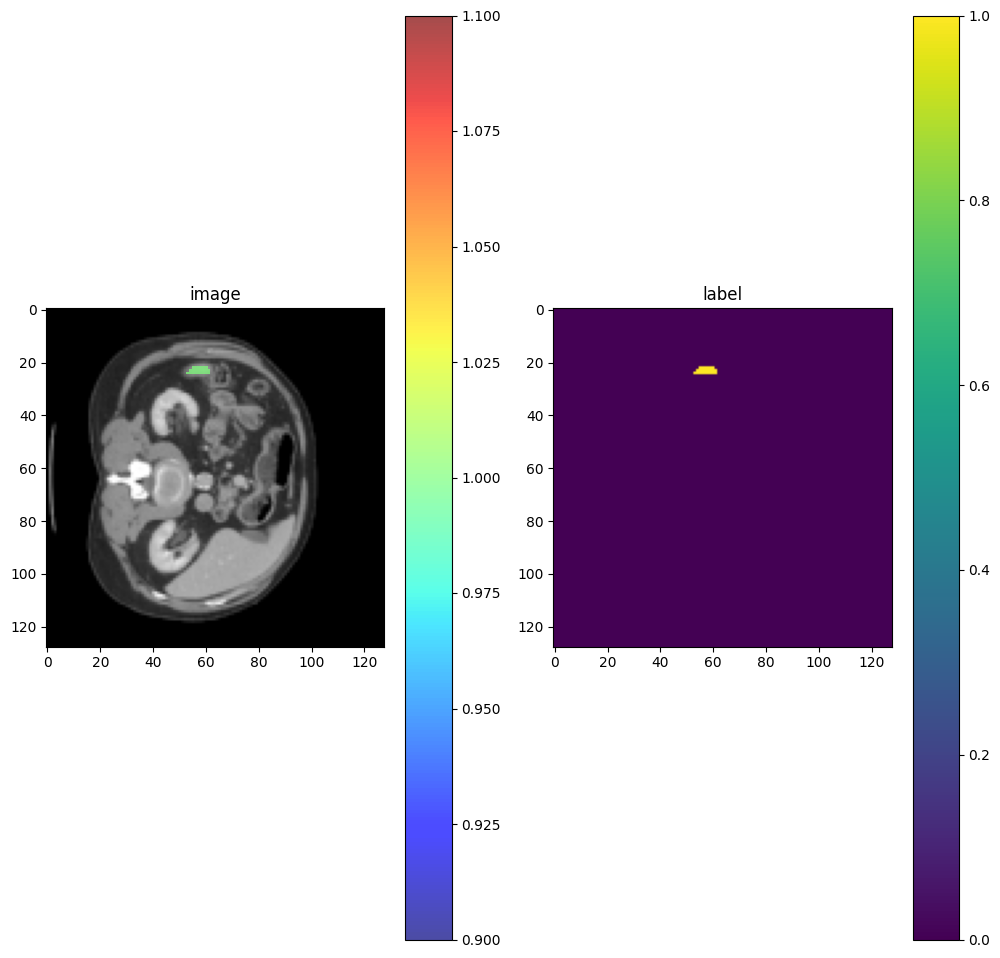

Final PLOT:: 60 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 225.0


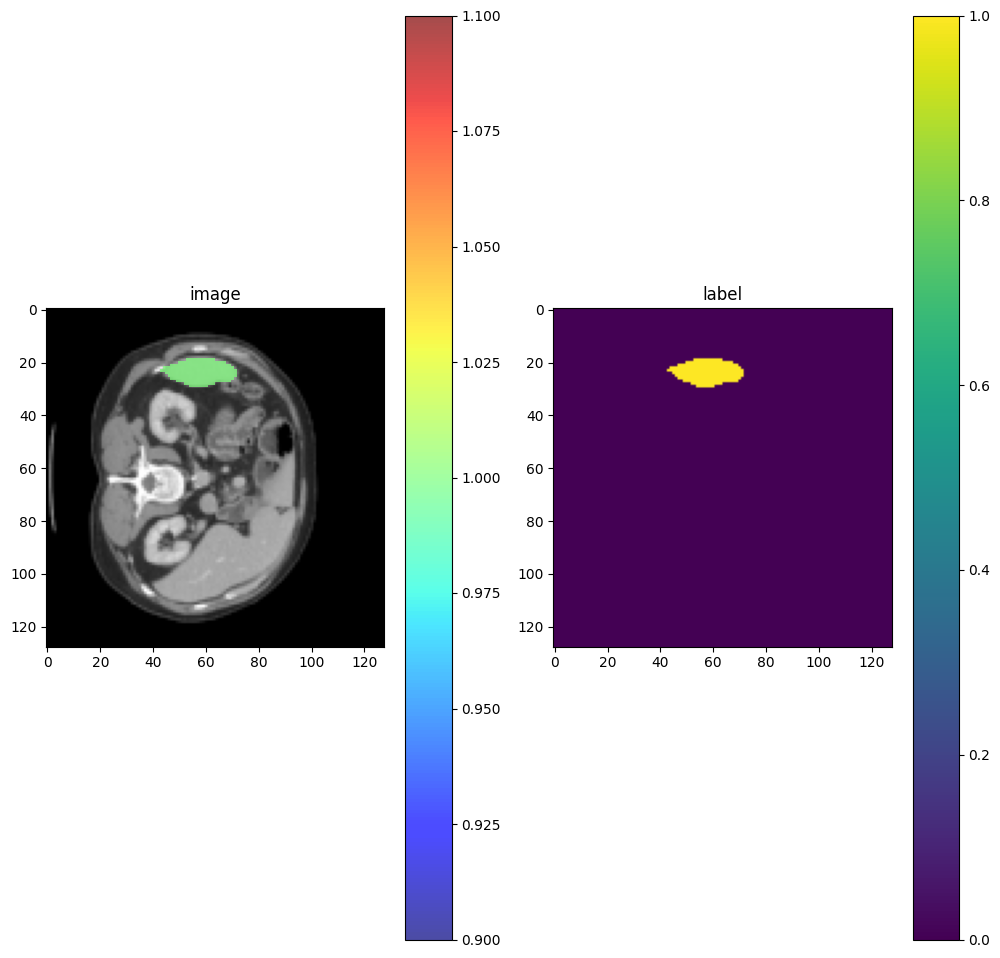

Final PLOT:: 70 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 327.0


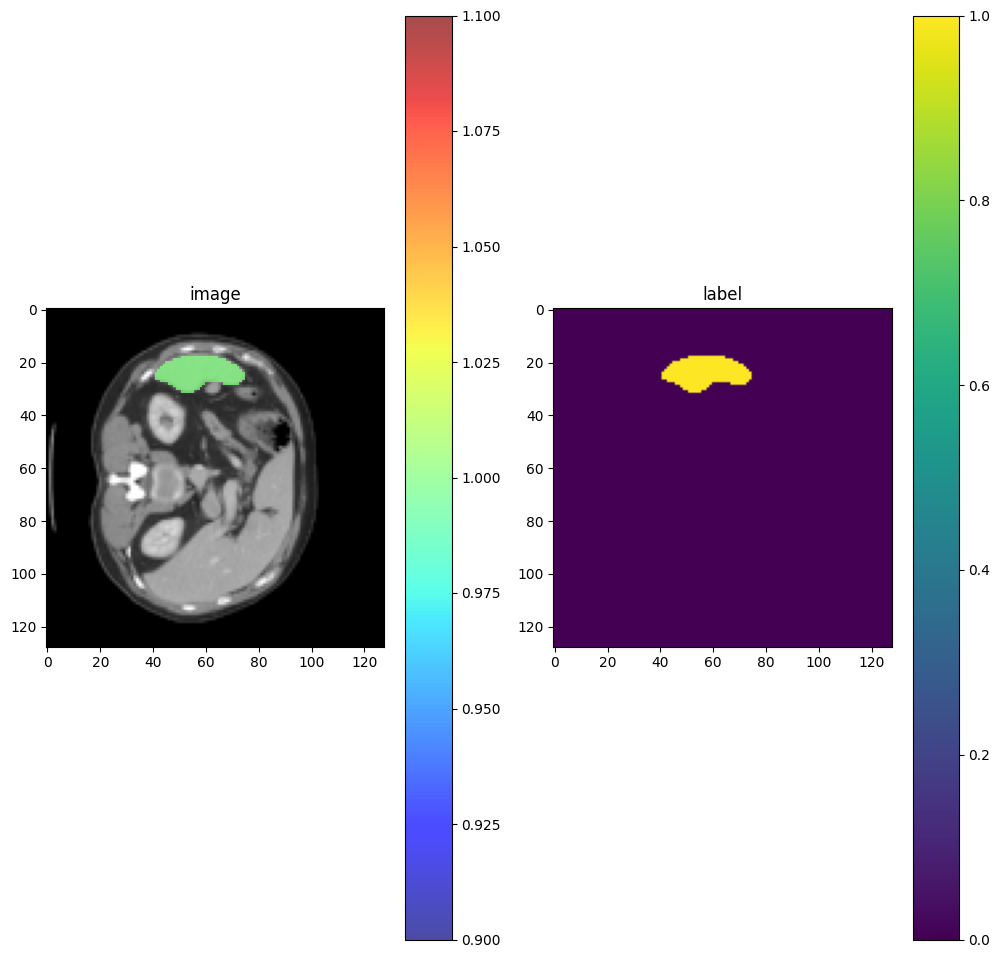

Final PLOT:: 80 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 390.0


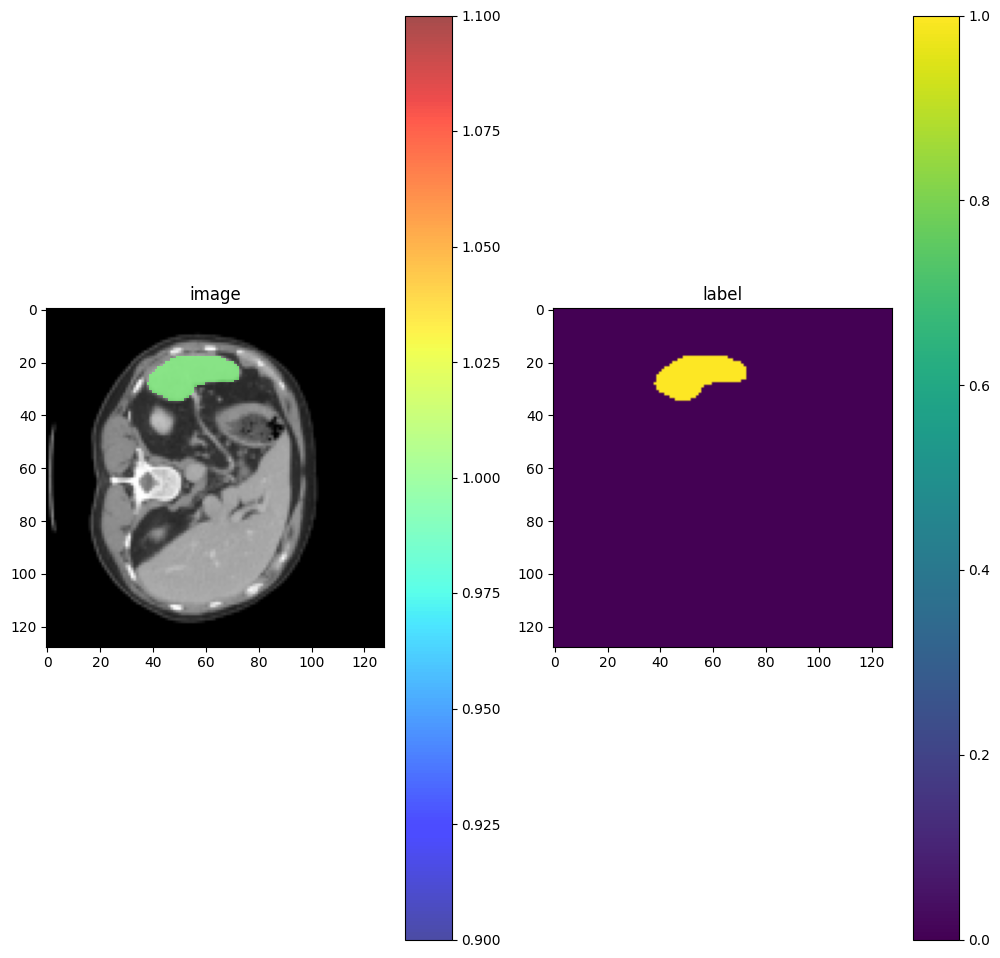

Final PLOT:: 90 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 386.0


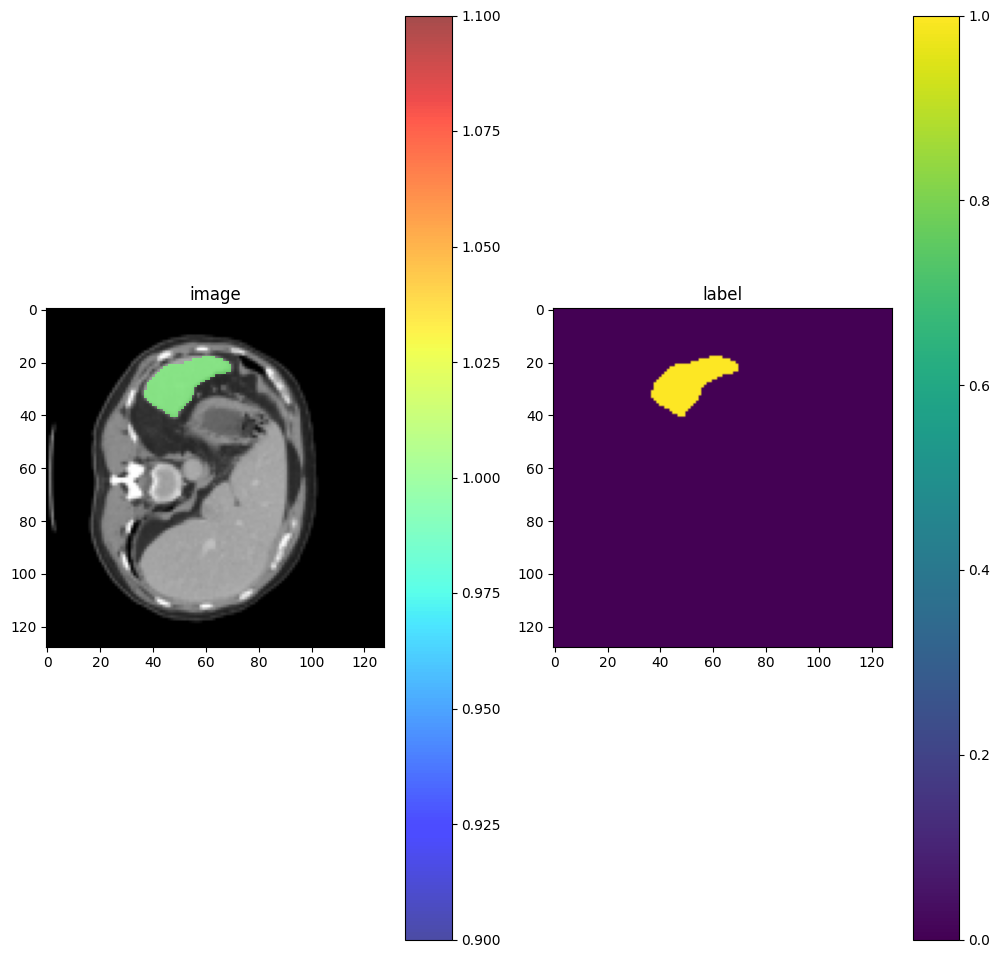

Final PLOT:: 100 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 316.0


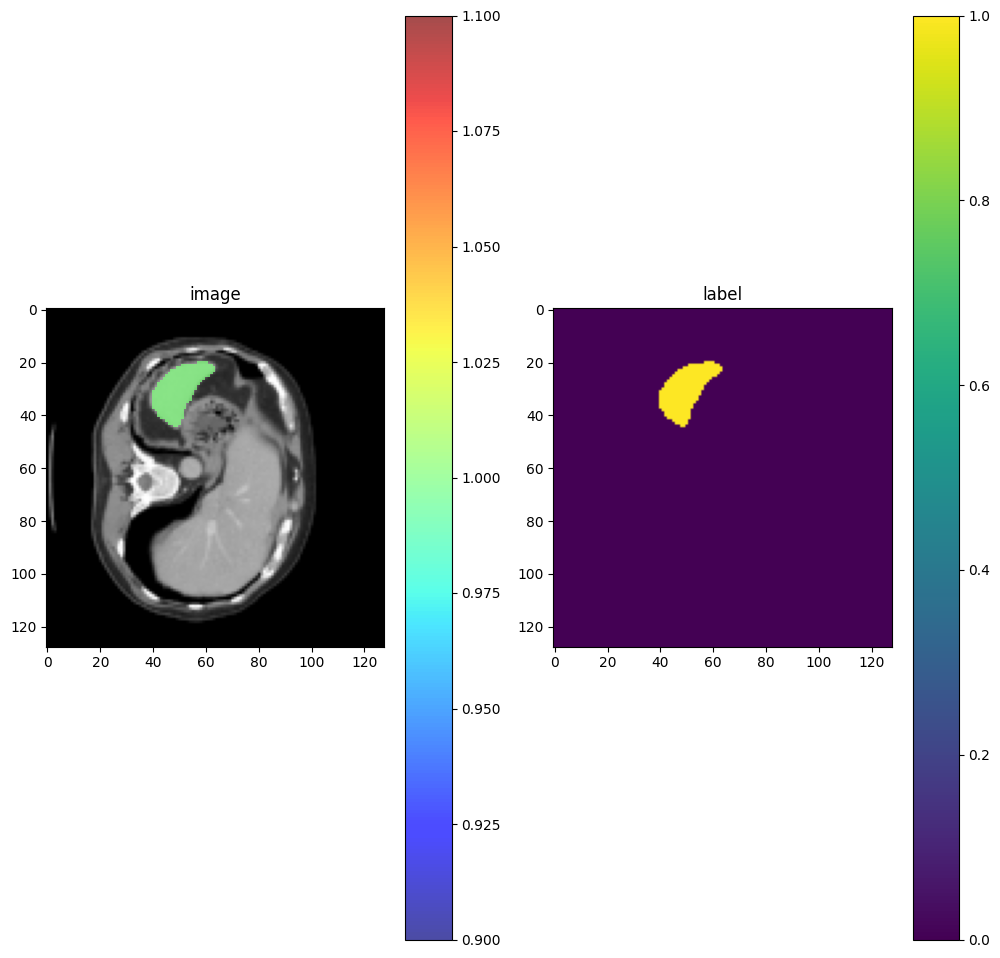

In [8]:
# Evaluation
model_path = "pretrained_deepedit_dynunet-final.pt"
model.load_state_dict(torch.load(model_path, weights_only=True))
model.cuda()
model.eval()

inputs = data["image"][None].cuda()
with torch.no_grad():
    outputs = model(inputs)
outputs = outputs[0]
data["pred"] = outputs

post_transforms = [
    EnsureTyped(keys="pred"),
    Activationsd(keys="pred", softmax=True),
    AsDiscreted(keys="pred", argmax=True),
    SqueezeDimd(keys="pred", dim=0),
    ToNumpyd(keys="pred"),
]

pred = None
for t in post_transforms:
    tname = type(t).__name__
    data = t(data)
    image = data["image"]
    label = data["pred"]
    print("{} => image shape: {}, pred shape: {}".format(tname, image.shape, label.shape))

for i in range(10, 110, 10):
    image = transformed_image[0, :, :, i]  # Taking the first channel which is the main image
    label = data["pred"][:, :, i]
    if np.sum(label) == 0:
        continue

    print(
        "Final PLOT:: {} => image shape: {}, pred shape: {}; min: {}, max: {}, sum: {}".format(
            i, image.shape, label.shape, np.min(label), np.max(label), np.sum(label)
        )
    )
    show_image(image, label)